# Bayesian vital–rate model linking climate to individual size and population growth

This notebook builds a **hierarchical, individual-based state-space model** in three layers:

| layer | sub-model | response | predictors | link / distribution |
|-------|-----------|----------|------------|---------------------|
| **Survival** | probability that an individual alive at *t* is still alive at *t + 1* | 0/1 (latent) | *size* at *t*, 3 climate covariates | logistic → Bernoulli |
| **Growth** | size at *t + 1* conditional on survival | continuous | *size* at *t*, 3 climate covariates | identity → Normal |
| **Births** | number of new recruits between *t* and *t + 1* | non-negative count | previous population size, 3 climate covariates | log → Poisson |

---

## Why this structure?

* **State space** The latent survival indicator lets the sampler propagate uncertainty about deaths and births, not just treat missing data as zeros.  
* **Vital-rate decomposition** Survival, growth, and recruitment can respond to climate in *different* ways. For example, warm years may boost growth but not survival.  
* **Population feedback** Recruitment includes a *density term* (φ × *N<sub>t</sub>*), letting us detect Allee effects or crowding.  
* **Weakly-informative priors** All regression coefficients follow *Normal(0, 1)*, appropriate because predictors are z-scored; the growth residual uses *HalfNormal(1)*. These priors regularise the model without swamping real signals.

---

## How inference is performed

1. **ADVI warm-up** 20 000 variational iterations find a region of high posterior density and a sensible mass matrix (avoids zero-gradient errors).  
2. **Posterior draws** 1 500 samples are drawn from the variational approximation (you can switch to full NUTS once the model is numerically stable).  

The posterior object contains:

* regression coefficients (α, β, γ, δ, ρ, φ)  
* residual scale (σ<sub>grow</sub>)  
* derived Poisson means λ<sub>t</sub> for births

---

## What we get out

* **Effect sizes** – posterior means and 94 % HDIs for every climate coefficient tell us which environmental variables matter and in what direction.  
* **Elasticities** – marginal-effect plots convert abstract “per-SD” slopes into predicted centimetres of growth or expected extra births.  
* **Posterior-predictive checks** – box plots of replicated birth counts vs. observed points gauge overall model fit.  
* **Scenario exploration** – because all predictors are in `pm.MutableData`, you can plug in any future climate series (or ±1 SD shocks) and draw new size trajectories and population forecasts without re-fitting.  

In short, the model bridges **individual physiology** (size & survival) and **population demography** (recruitment) while explicitly quantifying how each step is modulated by climate.

## Appendix A | Model setup for thaw-slump occurrence and expansion  

This notebook treats every retrogressive thaw slump (RTS) as a tracked “individual.”  
Climate covariates drive three vital rates—persistence, areal expansion, and initiation—exactly as size–structured population models do for organisms.

| sub-model | response | linear predictor | distribution | priors (all weakly-informative) |
|-----------|----------|------------------|--------------|---------------------------------|
| **Persistence** of an active RTS face | `z_{i,t+1}` (1 = still active) | *η*<sub>i,t</sub> = α<sub>surv</sub> + β<sub>size</sub> *s*<sub>i,t</sub> + **β**<sub>clim</sub> · *c*<sub>t</sub> | `Bernoulli(logit⁻¹(η))` | α<sub>surv</sub>, β<sub>size</sub>, **β**<sub>clim</sub> ∼ N(0, 1) |
| **Expansion** (area gain) | `s_{i,t+1}` given survival | μ<sub>i,t</sub> = α<sub>grow</sub> + ρ *s*<sub>i,t</sub> + **γ** · *c*<sub>t</sub> | `StudentT(ν_grow, μ, σ_grow)` | α<sub>grow</sub>, ρ, **γ** ∼ N(0, 1); σ<sub>grow</sub> ∼ HalfNormal(1); ν<sub>grow</sub> = Exp(1/30)+2 |
| **Initiation** of new slumps per year | `b_t` | log λ<sub>t</sub> = α<sub>init</sub> + φ *N*<sub>t</sub> + **δ** · *c*<sub>t</sub> | `ZeroInflatedPoisson(ψ, λ)` | α<sub>init</sub>, φ, **δ** ∼ N(0, 1); ψ ∼ Beta(2, 2) |

**Symbols**

* *s*<sub>i,t</sub> – current slump area of entity *i*  
* *c*<sub>t</sub> – z-scored climate vector (temperature, precipitation, radiation)  
* *N*<sub>t</sub> – number of active slumps at year *t*  

**Why these likelihoods?**

* *Student-t* expansion handles rare, extreme retreat bursts better than a Gaussian.  
* Zero-inflated Poisson lets the model reproduce many 0-initiation years while still fitting climate-driven surges.

With posterior samples of all parameters we can:

1. **Quantify climate elasticities** of persistence, expansion, and initiation.  
2. **Forecast disturbed area** under CMIP6 scenarios by feeding future climate series into the same state-space simulator.  
3. Propagate every source of uncertainty—from slump detection to parameter estimation—into those forecasts.


## Appendix A | Model setup for thaw-slump occurrence and expansion  

This notebook treats every retrogressive thaw slump (RTS) as a tracked “individual.”  
Climate covariates drive three vital rates—persistence, areal expansion, and initiation—exactly as size–structured population models do for organisms.

| sub-model | response | linear predictor | distribution | priors (all weakly-informative) |
|-----------|----------|------------------|--------------|---------------------------------|
| **Persistence** of an active RTS face | `z_{i,t+1}` (1 = still active) | *η*<sub>i,t</sub> = α<sub>surv</sub> + β<sub>size</sub> *s*<sub>i,t</sub> + **β**<sub>clim</sub> · *c*<sub>t</sub> | `Bernoulli(logit⁻¹(η))` | α<sub>surv</sub>, β<sub>size</sub>, **β**<sub>clim</sub> ∼ N(0, 1) |
| **Expansion** (area gain) | `s_{i,t+1}` given survival | μ<sub>i,t</sub> = α<sub>grow</sub> + ρ *s*<sub>i,t</sub> + **γ** · *c*<sub>t</sub> | `StudentT(ν_grow, μ, σ_grow)` | α<sub>grow</sub>, ρ, **γ** ∼ N(0, 1); σ<sub>grow</sub> ∼ HalfNormal(1); ν<sub>grow</sub> = Exp(1/30)+2 |
| **Initiation** of new slumps per year | `b_t` | log λ<sub>t</sub> = α<sub>init</sub> + φ *N*<sub>t</sub> + **δ** · *c*<sub>t</sub> | `ZeroInflatedPoisson(ψ, λ)` | α<sub>init</sub>, φ, **δ** ∼ N(0, 1); ψ ∼ Beta(2, 2) |

**Symbols**

* *s*<sub>i,t</sub> – current slump area of entity *i*  
* *c*<sub>t</sub> – z-scored climate vector (temperature, precipitation, radiation)  
* *N*<sub>t</sub> – number of active slumps at year *t*  

**Why these likelihoods?**

* *Student-t* expansion handles rare, extreme retreat bursts better than a Gaussian.  
* Zero-inflated Poisson lets the model reproduce many 0-initiation years while still fitting climate-driven surges.

With posterior samples of all parameters we can:

1. **Quantify climate elasticities** of persistence, expansion, and initiation.  
2. **Forecast disturbed area** under CMIP6 scenarios by feeding future climate series into the same state-space simulator.  
3. Propagate every source of uncertainty—from slump detection to parameter estimation—into those forecasts.


   id       area  alive  new_init  year     temp_dd   prec_ext         rad
0   0   7.584108      1         1   0.0  824.377366  25.435473  188.517688
1   1   6.219119      1         1   0.0  824.377366  25.435473  188.517688
2   2  13.316669      1         1   0.0  824.377366  25.435473  188.517688
3   3   7.676688      1         1   0.0  824.377366  25.435473  188.517688
4   4   6.880346      1         1   0.0  824.377366  25.435473  188.517688


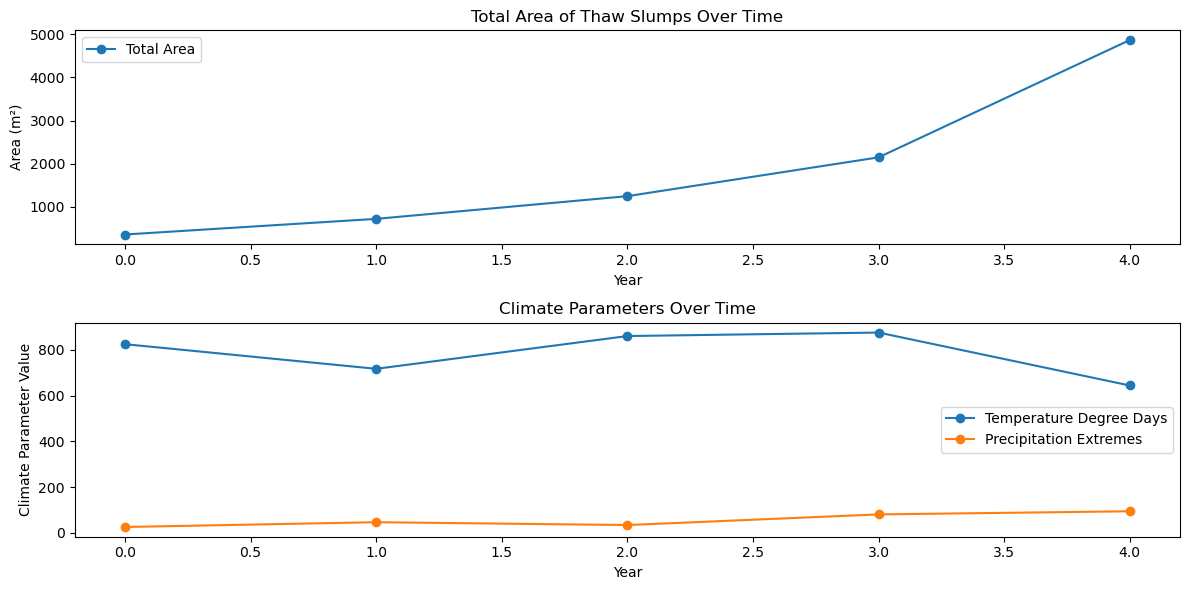

In [11]:
# first we need some data. Here we generate a time series of thaw slums and climate parameters. New slumps for example
# are initiated by rainfall, and existing slumps can fail due to hot summers. While in traditional state space model we look at newborns that change in survive and change in size,
# here we look at the area of thaw slumps, new ones are initiated and then persist. 

# This is a synthetic example, but it can be used to illustrate the concepts of Bayesian state space models.


import numpy as np, pandas as pd

def simulate_thaw_slump_data(
        n_init=40, n_years=5, ice_area=100,
        base_persist=0.85, beta_tdd=-0.10, beta_prec=0.35, seed=42):

    rng = np.random.default_rng(seed)

    # ----- synthetic climate -----
    clim = pd.DataFrame({
        "year":     np.arange(n_years),
        "temp_dd":  rng.normal(800,  80, n_years),      # °C·day
        "prec_ext": rng.gamma(4,    15, n_years),       # mm
        "rad":      rng.normal(210, 25, n_years)        # W m-2
    })

    # z-scores (now on one complete line)
    clim_z = (clim[["temp_dd", "prec_ext", "rad"]] -
              clim[["temp_dd", "prec_ext", "rad"]].mean()) / \
             clim[["temp_dd", "prec_ext", "rad"]].std()

    rec, alive_ids, next_id = [], [], 0

    # ----- initial population -----
    init_sizes = rng.lognormal(mean=2.1, sigma=0.4, size=n_init)
    row0 = clim.loc[0]           # already contains year = 0
    for s in init_sizes:
        rec.append(dict(id=next_id, area=s, alive=1, new_init=1, **row0))
        alive_ids.append(next_id)
        next_id += 1

    # ----- annual loop -----
    for t in range(1, n_years):
        row, row_z = clim.loc[t], clim_z.loc[t]
        survivors  = []

        # persistence & growth -----------------------------------
        for ind in alive_ids:
            last = next(r for r in rec if r["id"] == ind and r["year"] == t-1)
            p_surv = base_persist + beta_tdd * row_z["temp_dd"]

            if rng.random() < p_surv:     # survives
                g_mean  = 0.12 + 0.05*row_z["prec_ext"] + 0.04*row_z["temp_dd"]
                growth  = rng.lognormal(mean=g_mean, sigma=0.35)
                rec.append(dict(id=ind, area=last["area"]*(1+growth),
                                alive=1, new_init=0, **row))
                survivors.append(ind)
            else:                         # fails
                rec.append(dict(id=ind, area=np.nan,
                                alive=0, new_init=0, **row))

        # new initiations ----------------------------------------
        n_new = 0
        if row_z["prec_ext"] > 0.3:
            lam   = np.exp(beta_prec * row_z["prec_ext"]) * ice_area / 100
            n_new = rng.poisson(lam)

        for _ in range(n_new):
            rec.append(dict(id=next_id,
                            area=rng.lognormal(mean=2.0, sigma=0.3),
                            alive=1, new_init=1, **row))
            survivors.append(next_id)
            next_id += 1

        alive_ids = survivors

    return pd.DataFrame(rec), clim

df, clim = simulate_thaw_slump_data()
print(df.head())

# visualize the popluation and area as well as climate parameters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.groupby("year")["area"].sum(), marker='o', label='Total Area')
plt.title('Total Area of Thaw Slumps Over Time')
plt.xlabel('Year')
plt.ylabel('Area (m²)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(clim['year'], clim['temp_dd'], label='Temperature Degree Days', marker='o')
plt.plot(clim['year'], clim['prec_ext'], label='Precipitation Extremes', marker='o')
plt.title('Climate Parameters Over Time')
plt.xlabel('Year')
plt.ylabel('Climate Parameter Value')
plt.legend()
plt.tight_layout()
plt.show()




c:\Users\castad001\AppData\Local\miniconda3\miniconda\envs\plotting\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 568.76
arviz - WARNING - Shape validation failed: input_shape: (1, 1500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_surv,0.70,0.41,-0.06,1.48,0.01,0.01,1488.54,1411.59,NaN
beta_size,0.04,0.04,-0.04,0.12,0.00,0.00,1644.44,1407.70,NaN
beta_clim[0],0.91,0.50,-0.02,1.86,0.01,0.01,1503.89,1523.41,NaN
beta_clim[1],-0.62,0.39,-1.37,0.11,0.01,0.01,1704.39,1535.93,NaN
beta_clim[2],0.52,0.35,-0.12,1.16,0.01,0.01,1552.46,1361.59,NaN
alpha_grow,0.70,0.61,-0.53,1.77,0.02,0.01,1274.47,1288.56,NaN
rho,2.06,0.04,1.98,2.14,0.00,0.00,1533.07,1449.89,NaN
gamma_clim[0],0.57,0.80,-0.88,2.11,0.02,0.02,1340.73,1197.70,NaN
gamma_clim[1],0.39,0.60,-0.72,1.47,0.02,0.01,1483.03,1581.88,NaN
gamma_clim[2],0.90,0.60,-0.25,1.98,0.02,0.01,1351.05,1410.61,NaN


Sampling: [new_slumps]


Output()

alpha_surv     Intercept: baseline survival log-odds
beta_size      Size slope on survival
beta_clim[0]   Temp DD slope on survival
beta_clim[1]   Extreme precip slope on survival
beta_clim[2]   Radiation slope on survival
alpha_grow     Intercept: baseline growth
rho            Autoregressive size effect
gamma_clim[0]  Temp DD slope on growth
gamma_clim[1]  Extreme precip slope on growth
gamma_clim[2]  Radiation slope on growth
sigma_grow     Residual SD (growth)
alpha_init     Intercept: baseline initiation
phi            Density feedback on initiations
delta_clim[0]  Temp DD slope on initiation
delta_clim[1]  Extreme precip slope on initiation
delta_clim[2]  Radiation slope on initiation
psi            Zero-inflation probability
nu_grow        Student-t degrees-of-freedom


C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\3036274649.py:200: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(y_rep, positions=np.arange(1, T), labels=np.arange(1, T))


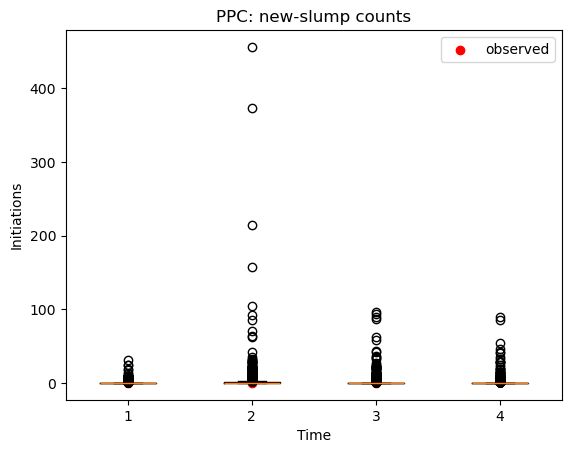

In [19]:
import arviz as az
import pymc as pm
from IPython.display import display


T  = clim.shape[0] # number of years
ids = df.id.unique();  I = len(ids) # number of individuals

# 
area_mat  = np.full((I, T), np.nan)  # area of thaw slumps        
alive_mat = np.zeros((I, T), dtype=int) # alive status (1 = alive, 0 = dead)

id2idx = {i: k for k, i in enumerate(ids)} # map id to index

# fill matrices with data
for _, r in df.iterrows():
    i, t = id2idx[r.id], int(r.year)
    area_mat[i, t]  = r.area                
    alive_mat[i, t] = r.alive


clim_raw = clim[["temp_dd", "prec_ext", "rad"]].values   # climate variables
clim_mat = (clim_raw - clim_raw.mean(0)) / clim_raw.std(0) # z-score each variable, how ar away from mean


# build survival and growth data for the model
def build_surv_grow():
    surv_area, surv_clim, surv_out = [], [], []
    grow_prev, grow_clim, grow_next = [], [], [] 
    for t in range(T-1):
        for i in range(I):
            if alive_mat[i, t]:
                surv_area.append(area_mat[i, t])
                surv_clim.append(clim_mat[t])
                surv_out.append(alive_mat[i, t+1])

                if alive_mat[i, t+1]:
                    grow_prev.append(area_mat[i, t])
                    grow_clim.append(clim_mat[t])
                    grow_next.append(area_mat[i, t+1])

    return map(np.asarray,
               (surv_area, surv_clim, surv_out,
                grow_prev, grow_clim, grow_next))

(surv_area, surv_clim, surv_out,
 grow_prev, grow_clim, grow_next) = build_surv_grow()

# births:  z-score N_prev  +  climate already z-scored
N_t        = alive_mat.sum(axis=0)
birth_cnts = (df[df.new_init == 1]           
                .groupby("year").size()
                .reindex(range(T), fill_value=0)
                .values)

birth_clim = clim_mat[1:]                    
N_prev     = (N_t[:-1] - N_t[:-1].mean()) / N_t[:-1].std()


# configure the PyMC model. Here we use a Bayesian state space model to estimate the parameters of the survival, growth, and initiation processes.
with pm.Model() as pop_model:

    # ---------------- data holders ----------------
    # MutableData allows us to use data that is not fixed, but can be updated
    # during the model fitting process. This is useful for time series data.

    S_size   = pm.MutableData("S_area", surv_area)
    S_clim   = pm.MutableData("S_clim", surv_clim)
    S_out    = pm.MutableData("S_out",  surv_out)

    G_prev   = pm.MutableData("G_prev", grow_prev)
    G_clim   = pm.MutableData("G_clim", grow_clim)
    G_next   = pm.MutableData("G_next", grow_next)

    B_cnt    = pm.MutableData("B_cnt",  birth_cnts[1:])   # new slumps
    B_clim   = pm.MutableData("B_clim", birth_clim)
    N_prev_d = pm.MutableData("N_prev", N_prev)

    # ---------------- persistence (logistic) --------------------
    # Here we model the probability of survival of existing slumps based on their size and climate conditions.
    # The logistic regression is used to model the probability of survival, which is a common approach in survival analysis.
    # The coefficients are estimated using a normal prior distribution.

    alpha_surv = pm.Normal("alpha_surv", 0, 1)
    beta_size  = pm.Normal("beta_size", 0, 1)
    beta_clim  = pm.Normal("beta_clim", 0, 1, shape=3)

    # The logit link function is used to model the probability of survival.
    # The logit function transforms the linear combination of predictors into a probability.
    logit_p = alpha_surv + beta_size*S_size + pm.math.sum(S_clim*beta_clim, axis=1)

    # The Bernoulli distribution is used to model the binary outcome of survival (1) or death (0).
    # The observed data is the survival status of the slumps. The model estimates the probability of survival based on the size and climate conditions.
    pm.Bernoulli("persistence", logit_p=logit_p, observed=S_out)

    # ---------------- expansion (Student-t) ---------------------
    # Here we define priors for the parameters of the growth model.
    # The growth model predicts the size of slumps in the next year based on their current size and climate conditions.
    # We use a Student-t distribution to model the growth, which is robust to outliers and allows for heavy-tailed distributions.
    # The Student-t distribution is parameterized by its mean, scale (standard deviation), and degrees of freedom (nu).
    alpha_grow = pm.Normal("alpha_grow", 0, 1)
    rho        = pm.Normal("rho", 0, 1)
    gamma_clim = pm.Normal("gamma_clim", 0, 1, shape=3)
    sigma_grow = pm.HalfNormal("sigma_grow", 1)
    nu_grow    = pm.Exponential("nu_grow", 1/30) + 2        # df > 2

    mu_grow = alpha_grow + rho*G_prev + pm.math.sum(G_clim*gamma_clim, axis=1)
    pm.StudentT("expansion", mu=mu_grow, sigma=sigma_grow, nu=nu_grow,
                observed=G_next)

    # -------------- new-slump initiations  ----------------------
    # Here we model the number of new slumps initiated each year based on the previous year's population size and climate conditions.
    # We use a zero-inflated Poisson distribution to model the count of new slumps. 
    # The zero-inflated Poisson distribution allows for excess zeros in the data, which is common in count data where many years have no new slumps.
    alpha_init  = pm.Normal("alpha_init", 0, 1)
    phi         = pm.Normal("phi", 0, 1)
    delta_clim  = pm.Normal("delta_clim", 0, 1, shape=3)

    # The log-linear model for the expected number of new slumps is defined.
    log_lambda  = alpha_init + phi*N_prev_d + pm.math.sum(B_clim*delta_clim, axis=1)
    lambda_raw  = pm.math.exp(log_lambda)
    lambda_safe = pm.math.clip(lambda_raw, 1e-9, 1e6)

    # probability of a structural zero (year with no new slumps)
    psi = pm.Beta("psi", 2, 2)                     # weakly centred at 0.5

    # The ZeroInflatedPoisson distribution is used to model the count of new slumps.
    # It combines a Bernoulli distribution for the zero-inflation and a Poisson distribution for the count data.

    pm.ZeroInflatedPoisson("new_slumps",
                           psi=psi,
                           mu=lambda_safe,
                           observed=B_cnt)

    # -------------- inference (ADVI warm-up → samples) ----------
    approx = pm.fit(20_000, method="advi", progressbar=True)
    trace  = approx.sample(1_500, random_seed=2025)




    # posterior predictive checks (PPC) and diagnostics
    # this summary will show the posterior distributions of the model parameters, It will tell us which parameters effect the suvival, growth, and initiation of thaw slumps in which way.
    summary = az.summary(
            trace,
            round_to=2,
            var_names=[
                "alpha_surv", "beta_size", "beta_clim",
                "alpha_grow", "rho", "gamma_clim", "sigma_grow",
                "alpha_init",          # ← renamed
                "phi", "delta_clim",
                "psi", "nu_grow"       # ← zero-inflation & Student-t df (optional)
            ],
        )
    
    display(summary)

    param_expl = [
    ("alpha_surv",   "Intercept: baseline survival log-odds"),
    ("beta_size",    "Size slope on survival"),
    ("beta_clim[0]", "Temp DD slope on survival"),
    ("beta_clim[1]", "Extreme precip slope on survival"),
    ("beta_clim[2]", "Radiation slope on survival"),
    ("alpha_grow",   "Intercept: baseline growth"),
    ("rho",          "Autoregressive size effect"),
    ("gamma_clim[0]","Temp DD slope on growth"),
    ("gamma_clim[1]","Extreme precip slope on growth"),
    ("gamma_clim[2]","Radiation slope on growth"),
    ("sigma_grow",   "Residual SD (growth)"),
    ("alpha_init",   "Intercept: baseline initiation"),
    ("phi",          "Density feedback on initiations"),
    ("delta_clim[0]","Temp DD slope on initiation"),
    ("delta_clim[1]","Extreme precip slope on initiation"),
    ("delta_clim[2]","Radiation slope on initiation"),
    ("psi",          "Zero-inflation probability"),
    ("nu_grow",      "Student-t degrees-of-freedom"),
]

# Print the hard-coded list in aligned columns
    colw = max(len(p) for p, _ in param_expl) + 2
    for p, d in param_expl:
        print(f"{p:<{colw}}{d}")


    # posterior-predictive draws (dict, not InferenceData) 
    with pop_model:
        ppc = pm.sample_posterior_predictive(
            trace,
            var_names=["new_slumps"],          
            return_inferencedata=False,
            progressbar=True,
        )

    y_rep = ppc["new_slumps"]                  
    if y_rep.ndim == 3:
        y_rep = y_rep.reshape(-1, y_rep.shape[-1])


    # This plot shows the posterior predictive distribution of new slumps compared to the observed counts.
    plt.boxplot(y_rep, positions=np.arange(1, T), labels=np.arange(1, T))
    plt.scatter(np.arange(1, T), birth_cnts[1:], c="red", label="observed")
    plt.ylabel("Initiations"); plt.xlabel("Time")
    plt.title("PPC: new-slump counts"); plt.legend(); plt.show()


C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\2686340124.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]


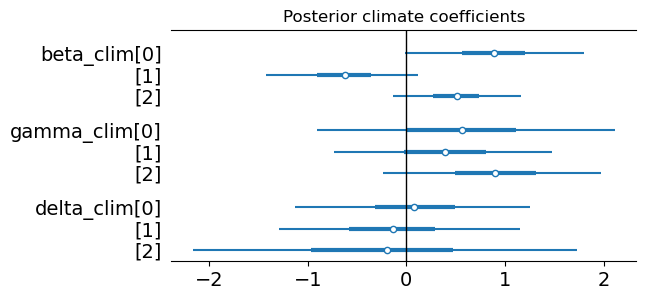

In [13]:
# We can also visualise the impacts of climate on the survival, growth, and initiation of thaw slumps. 
clim_labels = ["temperature degree-days", "precipitation extremes", "radiation"]
n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]

# We can  plot the posterior distributions of the climate coefficients to see how they impact the survival, growth, and initiation of thaw slumps.
az.plot_forest(
    trace,
    var_names=[r"beta_clim", r"gamma_clim", r"delta_clim"],
    combined=True,  # merge chains
    figsize=(6, 3),
)
plt.axvline(0, color="k", lw=1)
plt.title("Posterior climate coefficients"); plt.show()



C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)


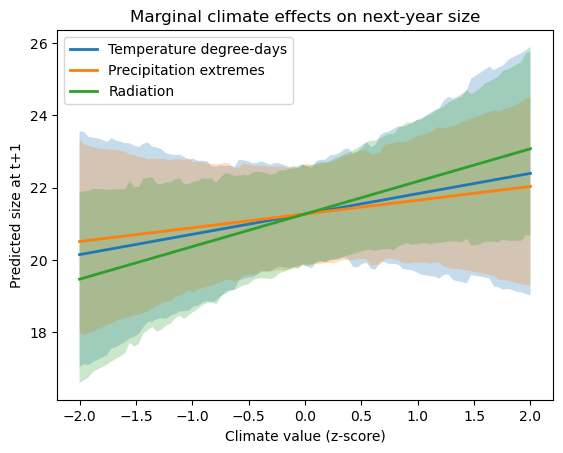

In [14]:
# Maybe we wamt to see the marginal effects of each climate variable on the next year's size of thaw slumps.
alpha  = trace.posterior["alpha_grow"].stack(samples=("chain", "draw")).values       # (n_draws,)
rho  = trace.posterior["rho"].stack(samples=("chain", "draw")).values           # (n_draws,)
gamma  = trace.posterior["gamma_clim"].stack(samples=("chain", "draw")).values      # (3, n_draws)

s0 = 10                                 # reference current size
grid = np.linspace(-2, 2, 100)          # ±2 SD for each climate var

for j, lab in enumerate(clim_labels):
    X = np.zeros((grid.size, 3))
    X[:, j] = grid                      # vary ONE covariate, others kept at 0
    mu = alpha[None, :] + rho[None, :] * s0 + (X @ gamma)      # (grid, draws)

    mu_mean = mu.mean(1)
    mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)

    plt.fill_between(grid, mu_hdi[:, 0], mu_hdi[:, 1], alpha=0.25)
    plt.plot(grid, mu_mean, lw=2, label=lab.capitalize())

plt.xlabel("Climate value (z-score)")
plt.ylabel("Predicted size at t+1")
plt.title("Marginal climate effects on next-year size")
plt.legend(); plt.show()





C:\Users\castad001\AppData\Local\Temp\ipykernel_18932\2086612389.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  init_hdi   = az.hdi(init_preds.T, 0.94)


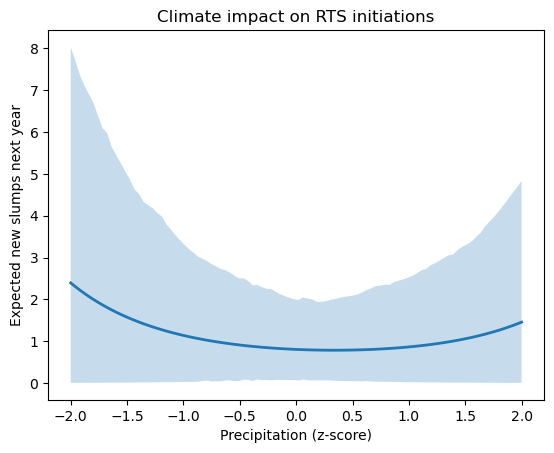

In [15]:
#The elasticities of the growth model can be visualised to see how sensitive the growth is to changes in climate variables.
alpha_i = trace.posterior["alpha_init"].stack(samples=("chain","draw")).values
phi     = trace.posterior["phi"].stack(samples=("chain","draw")).values
delta   = trace.posterior["delta_clim"].stack(samples=("chain","draw")).values

N_mean  = N_prev.mean()
prec_grid = grid
init_preds = []

for prec in prec_grid:
    X = np.array([0, prec, 0])            # vary precipitation only
    loglam = alpha_i + phi * N_mean + (delta.T @ X)
    init_preds.append(np.exp(loglam))

init_preds = np.array(init_preds)
init_mean  = init_preds.mean(1)
init_hdi   = az.hdi(init_preds.T, 0.94)

plt.fill_between(prec_grid, init_hdi[:,0], init_hdi[:,1], alpha=.25)
plt.plot(prec_grid, init_mean, lw=2)
plt.xlabel("Precipitation (z-score)")
plt.ylabel("Expected new slumps next year")
plt.title("Climate impact on RTS initiations"); plt.show()